In [1]:
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import xtrack as xt
import xpart as xp

xt.enable_pyheadtail_interface()

PyHEADTAIL v1.16.1


In [3]:
# Import in Xsuite
line = xt.Line.from_json('./pimms_00_optics.json')
tw4d = line.twiss(method='4d')

Loading line from dict:   0%|          | 0/224 [00:00<?, ?it/s]

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


In [4]:
line.vars.get_table().rows['.*rf']

Table: 2 rows, 2 cols
name       value
vrf            0
frf            0

In [5]:
line.vars['vrf'] = 0.01 # MV
line.vars['frf'] = 1 / tw4d.T_rev0 / 1e6 # MHz, h=1

In [6]:
tw = line.twiss()

In [7]:
p = line.build_particles(zeta=np.linspace(0, tw.circumference/2, 20))

In [8]:
line.track(p, num_turns=2000, turn_by_turn_monitor=True, with_progress=True)

Tracking:   0%|          | 0/2000 [00:00<?, ?it/s]

In [9]:
mon = line.record_last_track

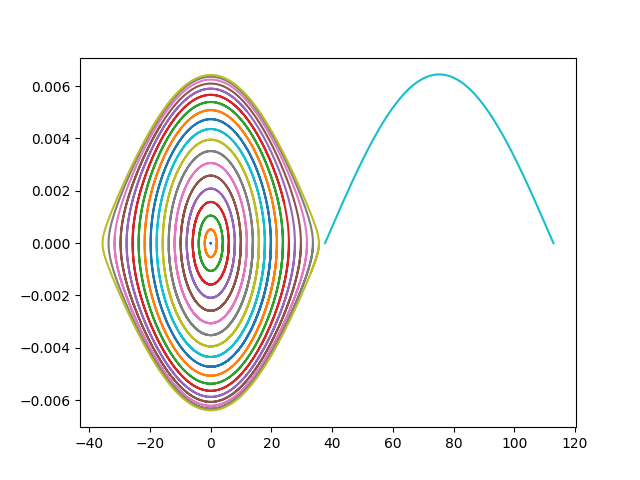

In [10]:
plt.figure()
plt.plot(mon.zeta.T, mon.delta.T);

In [11]:
from PyHEADTAIL.impedances import wakes
from PyHEADTAIL.particles.slicing import UniformBinSlicer


R_shunt = 10*10.2e6    # Shunt impedance [Ohm/m]
frequency = 1.3e6   # Resonance frequency [Hz]
Q = 1               # Quality factor

slices = 20
slicer_for_wakes = UniformBinSlicer(slices, n_sigma_z=6)

# Wake
wake = wakes.CircularResonator(R_shunt, frequency, Q)
wakefield = wakes.WakeField(slicer_for_wakes, wake)
wakefield.needs_hidden_lost_particles = True
line.discard_tracker()
line.append_element(name='wakefield', element=wakefield)
line.build_tracker()

Found suitable prebuilt kernel `default_only_xtrack`.


In [12]:
line.enable_time_dependent_vars = False
bunch = xp.generate_matched_gaussian_bunch(line=line,
    total_intensity_particles=1e11, nemitt_x=2e-6, nemitt_y=2e-6, sigma_z=10.,
    num_particles=1000)
bunch.circumference = tw.circumference

Ignoring collective elements in particles generation.


*** Maximum RMS bunch length 11.827306774060045m.
... distance to target bunch length: -1.0000e+01
... distance to target bunch length: 1.5294e+00
... distance to target bunch length: 1.4164e+00
... distance to target bunch length: -8.3951e-02
... distance to target bunch length: 1.3153e-01
... distance to target bunch length: 4.3249e-03
... distance to target bunch length: 1.3399e-04
... distance to target bunch length: -8.3374e-09
... distance to target bunch length: 2.0244e-05
--> Bunch length: 9.999999991662596


Ignoring collective elements in particles generation.


--> Emittance: 0.6118515375787399


In [13]:
bunch.x += 1e-3
track_log = xt.Log(x_mean=lambda line, bunch: bunch.x[bunch.state>0].mean()) 
line.enable_time_dependent_vars = True
line.track(bunch, log=track_log, num_turns=1000, with_progress=True)

Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

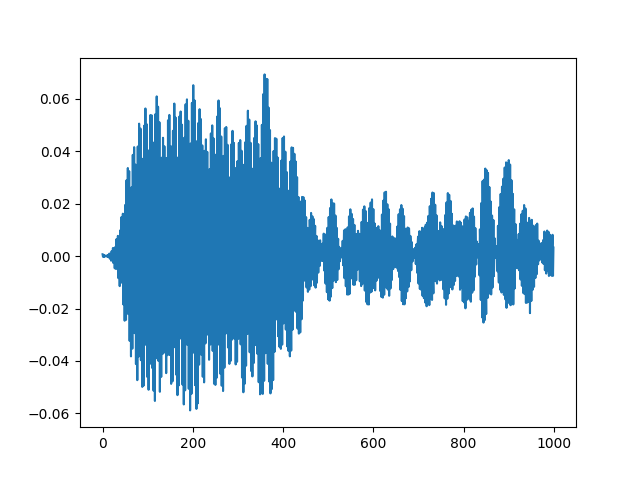

In [14]:
plt.figure()
plt.plot(line.log_last_track['x_mean'])

In [15]:
bunch.state

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1